In [1]:
import pandas as pd
import numpy as np
from pyjet import cluster,DTYPE_PTEPM
from sklearn import preprocessing

# Pre processing

In [2]:
path = path = '/anomalyvol/data/events_LHCO2020_backgroundMC_Pythia.h5'

In [3]:
df = pd.read_hdf(path,stop=1000) # just read first 1000 events

In [4]:
all_events = df.values

In [5]:
rows = all_events.shape[0]
cols = all_events.shape[1]
data = []

In [6]:
for i in range(rows):
    pseudojets_input = np.zeros(len([x for x in all_events[i][::3] if x > 0]), dtype=DTYPE_PTEPM)
    for j in range(cols // 3):
        if (all_events[i][j*3]>0):
            pseudojets_input[j]['pT'] = all_events[i][j*3]
            pseudojets_input[j]['eta'] = all_events[i][j*3+1]
            pseudojets_input[j]['phi'] = all_events[i][j*3+2]
        pass
    sequence = cluster(pseudojets_input, R=1.0, p=-1)
    jets = sequence.inclusive_jets()
    for k in range(len(jets)):
        jet = []
        jet.append(jets[k].pt)
        jet.append(jets[k].eta)
        jet.append(jets[k].phi)
        jet.append(jets[k].mass)
        data.append(jet)

In [7]:
data = np.array(data)
data.shape

(14795, 4)

In [8]:
# looking for bad data
bad_data = 0
for i in range(len(data)):
    if(0.0 in data[i]):
        bad_data += 1

In [9]:
(bad_data, len(data))

(439, 14795)

In [10]:
# checking distribution of data
(data[:][1].mean(), data[:][1].std()) # eta

(344.6350920188037, 387.5184029169282)

In [11]:
# regularize
min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(data)

# VAE Model

In [12]:
import keras
from keras.layers import Lambda, Input, Dense, Flatten, Reshape
from keras.models import Model, Sequential
from keras import metrics
from keras import backend as K

Using TensorFlow backend.


In [13]:
def sampling(args):
    """
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [14]:
inter_dim = 12
final_dim = 4
latent_dim = 2
input_dim = 4

In [15]:
# encoder
x = Input(shape=(input_dim,))
#x_flat = Flatten()(x)
h1 = Dense(inter_dim, activation='relu')(x)
h2 = Dense(final_dim, activation='relu')(h1)
z_mean = Dense(latent_dim)(h2)
z_log_sigma = Dense(latent_dim)(h2)

In [16]:
# random sampling
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

encoder = Model(inputs = x, outputs = z)

In [17]:
# decoder
decoder_h2 = Dense(final_dim, activation='relu')
decoder_h1 = Dense(inter_dim, activation='relu')
decoder_mean = Dense(input_dim, activation='sigmoid')

h2_decoded = decoder_h2(z)
h1_decoded = decoder_h1(h2_decoded)
x_decoded_mean = decoder_mean(h1_decoded)
# x_decoded = Reshape(input_shape)(x_decoded_mean)

In [18]:
vae = Model(inputs = x, outputs = x_decoded_mean, name = 'vae')

In [19]:
def vae_loss(x, y):
    xent_loss = metrics.binary_crossentropy(x, y)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss)

In [20]:
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12)           60          input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 4)            52          dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            10          dense_2[0][0]                    
________________________________________________________________________________________________

# Train

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
x_train = data[0:int(len(data) * 0.8)]
x_val = data[int(len(data) * 0.8):]
batch_size = 100
epochs = 200

In [23]:
x_train.shape

(11836, 4)

In [24]:
hist = vae.fit(x_train, x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_val, x_val))

Train on 11836 samples, validate on 2959 samples
Epoch 1/200
11836/11836 [==============================] - 1s 110us/step - loss: 0.6156 - val_loss: 0.5524
Epoch 2/200
11836/11836 [==============================] - 1s 50us/step - loss: 0.5058 - val_loss: 0.4702
Epoch 3/200
11836/11836 [==============================] - 1s 53us/step - loss: 0.4611 - val_loss: 0.4570
Epoch 4/200
11836/11836 [==============================] - 1s 55us/step - loss: 0.4541 - val_loss: 0.4534
Epoch 5/200
11836/11836 [==============================] - 1s 49us/step - loss: 0.4519 - val_loss: 0.4520
Epoch 6/200
11836/11836 [==============================] - 1s 50us/step - loss: 0.4513 - val_loss: 0.4520
Epoch 7/200
11836/11836 [==============================] - 1s 52us/step - loss: 0.4506 - val_loss: 0.4513
Epoch 8/200
11836/11836 [==============================] - 1s 50us/step - loss: 0.4500 - val_loss: 0.4504
Epoch 9/200
11836/11836 [==============================] - 1s 52us/step - loss: 0.4498 - val_loss: 0.4

11836/11836 [==============================] - 1s 48us/step - loss: 0.4487 - val_loss: 0.4497
Epoch 78/200
11836/11836 [==============================] - 1s 46us/step - loss: 0.4487 - val_loss: 0.4496
Epoch 79/200
11836/11836 [==============================] - 1s 48us/step - loss: 0.4487 - val_loss: 0.4496
Epoch 80/200
11836/11836 [==============================] - 1s 48us/step - loss: 0.4487 - val_loss: 0.4496
Epoch 81/200
11836/11836 [==============================] - 1s 48us/step - loss: 0.4487 - val_loss: 0.4496
Epoch 82/200
11836/11836 [==============================] - 1s 48us/step - loss: 0.4488 - val_loss: 0.4496
Epoch 83/200
11836/11836 [==============================] - 1s 48us/step - loss: 0.4487 - val_loss: 0.4496
Epoch 84/200
11836/11836 [==============================] - 1s 46us/step - loss: 0.4487 - val_loss: 0.4496
Epoch 85/200
11836/11836 [==============================] - 1s 46us/step - loss: 0.4487 - val_loss: 0.4497
Epoch 86/200
11836/11836 [========================

11836/11836 [==============================] - 1s 51us/step - loss: 0.4487 - val_loss: 0.4495
Epoch 154/200
11836/11836 [==============================] - 1s 49us/step - loss: 0.4487 - val_loss: 0.4496
Epoch 155/200
11836/11836 [==============================] - 1s 48us/step - loss: 0.4487 - val_loss: 0.4497
Epoch 156/200
11836/11836 [==============================] - 1s 51us/step - loss: 0.4487 - val_loss: 0.4496
Epoch 157/200
11836/11836 [==============================] - 1s 51us/step - loss: 0.4487 - val_loss: 0.4496
Epoch 158/200
11836/11836 [==============================] - 1s 50us/step - loss: 0.4487 - val_loss: 0.4497
Epoch 159/200
11836/11836 [==============================] - 1s 48us/step - loss: 0.4488 - val_loss: 0.4496
Epoch 160/200
11836/11836 [==============================] - 1s 51us/step - loss: 0.4487 - val_loss: 0.4497
Epoch 161/200
11836/11836 [==============================] - 1s 49us/step - loss: 0.4487 - val_loss: 0.4497
Epoch 162/200
11836/11836 [===============

# Visualization

In [25]:
import matplotlib.pyplot as plt

In [26]:
predictions = vae.predict(x_val)

In [27]:
predictions

array([[0.07021789, 0.5024749 , 0.48946273, 0.03610104],
       [0.07011582, 0.5020879 , 0.49071246, 0.03603751],
       [0.0704913 , 0.5022937 , 0.48980784, 0.03633823],
       ...,
       [0.0657272 , 0.49598828, 0.49200255, 0.03381502],
       [0.06968134, 0.50226235, 0.49050972, 0.03566827],
       [0.06950293, 0.50098455, 0.49147698, 0.03587788]], dtype=float32)

In [28]:
distr = (x_val - predictions) / x_val

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [29]:
pT_pred = [row[0] for row in predictions]
eta_pred = [row[1] for row in predictions]
phi_pred = [row[2] for row in predictions]
mass_pred = [row[3] for row in predictions]

In [30]:
pT = [row[0] for row in x_val]
eta = [row[1] for row in x_val]
phi = [row[2] for row in x_val]
mass = [row[3] for row in x_val]

## Stacking output (orange) over input (blue) for pT, eta, phi, m

(array([  8.,  35.,  70., 208., 353., 483., 627., 808., 319.,  48.]),
 array([0.05941861, 0.06090853, 0.06239845, 0.06388836, 0.06537828,
        0.06686819, 0.06835811, 0.06984803, 0.07133795, 0.07282786,
        0.07431778], dtype=float32),
 <a list of 10 Patch objects>)

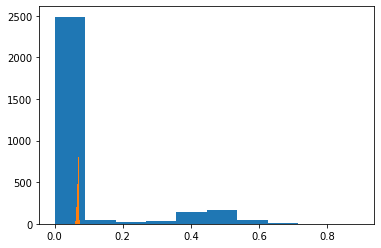

In [31]:
plt.hist(pT)
plt.hist(pT_pred)

(array([   5.,    7.,   24.,   72.,  147.,  283.,  414.,  468., 1039.,
         500.]),
 array([0.48663905, 0.48834032, 0.4900416 , 0.49174288, 0.49344414,
        0.49514544, 0.4968467 , 0.49854797, 0.50024927, 0.5019505 ,
        0.5036518 ], dtype=float32),
 <a list of 10 Patch objects>)

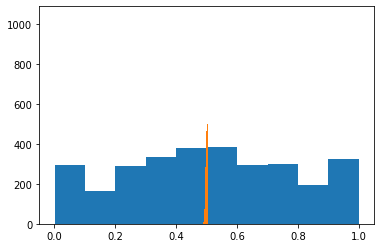

In [32]:
plt.hist(eta)
plt.hist(eta_pred)

(array([ 75., 408., 859., 941., 526., 138.,  11.,   0.,   0.,   1.]),
 array([0.4876659 , 0.48891526, 0.49016464, 0.49141404, 0.4926634 ,
        0.4939128 , 0.49516216, 0.49641153, 0.49766093, 0.4989103 ,
        0.5001597 ], dtype=float32),
 <a list of 10 Patch objects>)

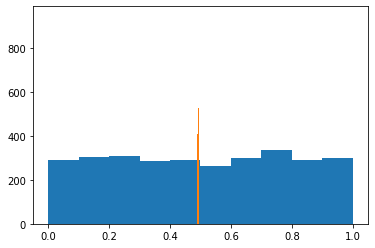

In [33]:
plt.hist(phi)
plt.hist(phi_pred)

(array([ 13.,  54., 156., 291., 529., 670., 729., 388., 107.,  22.]),
 array([0.03033241, 0.03126865, 0.03220489, 0.03314113, 0.03407737,
        0.03501361, 0.03594986, 0.0368861 , 0.03782234, 0.03875858,
        0.03969482], dtype=float32),
 <a list of 10 Patch objects>)

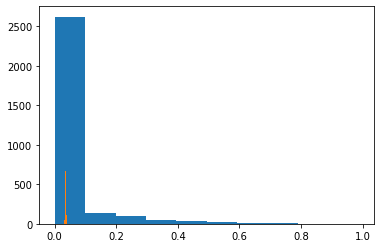

In [34]:
plt.hist(mass)
plt.hist(mass_pred)

In [35]:
d_pT = [row[0] for row in distr]
d_eta = [row[1] for row in distr]
d_phi = [row[2] for row in distr]
d_mass = [row[3] for row in distr]

## Distribution of (input - output) / input

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00,
        4.000e+00, 3.000e+00, 4.200e+01, 2.905e+03]),
 array([-1.84582113e+04, -1.66122979e+04, -1.47663845e+04, -1.29204711e+04,
        -1.10745577e+04, -9.22864427e+03, -7.38273086e+03, -5.53681745e+03,
        -3.69090404e+03, -1.84499063e+03,  9.22777406e-01]),
 <a list of 10 Patch objects>)

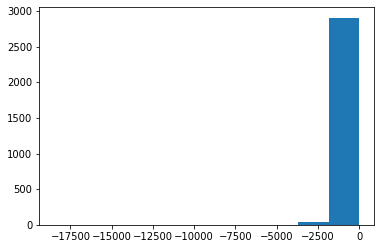

In [36]:
plt.hist(d_pT)

(array([1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 2.955e+03]),
 array([-3.21867856e+03, -2.89676042e+03, -2.57484227e+03, -2.25292412e+03,
        -1.93100598e+03, -1.60908783e+03, -1.28716969e+03, -9.65251541e+02,
        -6.43333395e+02, -3.21415250e+02,  5.02896039e-01]),
 <a list of 10 Patch objects>)

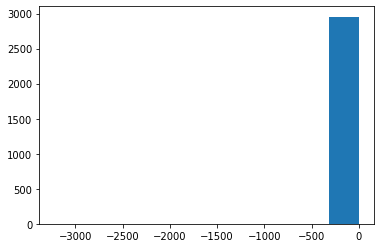

In [37]:
plt.hist(d_eta)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.958e+03]),
 array([-6.25504351e+03, -5.62948822e+03, -5.00393292e+03, -4.37837763e+03,
        -3.75282234e+03, -3.12726705e+03, -2.50171176e+03, -1.87615647e+03,
        -1.25060118e+03, -6.25045886e+02,  5.09405451e-01]),
 <a list of 10 Patch objects>)

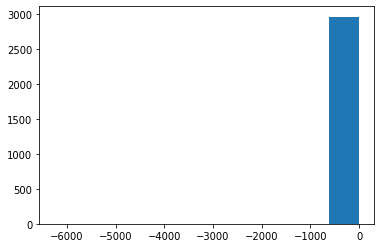

In [38]:
plt.hist(d_phi)